## Microsoft Stock forecasting with LSTMs

In [1]:
import pandas as pd
df = pd.read_csv('/content/MSFT.csv')

In [2]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9651,2024-07-01,448.660004,457.369995,445.660004,456.730011,456.730011,17662800
9652,2024-07-02,453.200012,459.589996,453.109985,459.279999,459.279999,13979800
9653,2024-07-03,458.190002,461.019989,457.880005,460.769989,460.769989,9932800
9654,2024-07-05,459.609985,468.350006,458.970001,467.559998,467.559998,16000300


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9656 non-null   object 
 1   Open       9656 non-null   float64
 2   High       9656 non-null   float64
 3   Low        9656 non-null   float64
 4   Close      9656 non-null   float64
 5   Adj Close  9656 non-null   float64
 6   Volume     9656 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 528.2+ KB


In [4]:
df = df[['Date','Close']]

In [5]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9651,2024-07-01,456.730011
9652,2024-07-02,459.279999
9653,2024-07-03,460.769989
9654,2024-07-05,467.559998


In [6]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9651    2024-07-01
9652    2024-07-02
9653    2024-07-03
9654    2024-07-05
9655    2024-07-08
Name: Date, Length: 9656, dtype: object

In [7]:
import datetime
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2010-01-01')
datetime_object

datetime.datetime(2010, 1, 1, 0, 0)

In [8]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9651,2024-07-01,456.730011
9652,2024-07-02,459.279999
9653,2024-07-03,460.769989
9654,2024-07-05,467.559998


In [9]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-9-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9651   2024-07-01
9652   2024-07-02
9653   2024-07-03
9654   2024-07-05
9655   2024-07-08
Name: Date, Length: 9656, dtype: datetime64[ns]

In [10]:
#now we want to make date column as index
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-07-01,456.730011
2024-07-02,459.279999
2024-07-03,460.769989


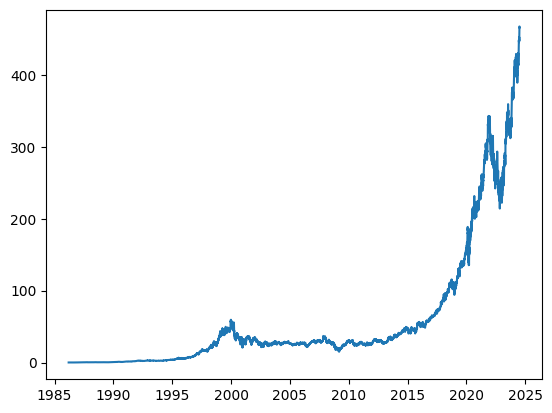

In [11]:
import matplotlib.pyplot as plt
plt.plot(df.index,df['Close'])

In [20]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2023-03-25'
windowed_df = df_to_windowed_df(df,
                                '2023-07-10',
                                '2024-07-08',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-07-10,338.149994,341.269989,337.220001,331.829987
1,2023-07-11,341.269989,337.220001,331.829987,332.470001
2,2023-07-12,337.220001,331.829987,332.470001,337.200012
3,2023-07-13,331.829987,332.470001,337.200012,342.660004
4,2023-07-14,332.470001,337.200012,342.660004,345.239990
...,...,...,...,...,...
246,2024-07-01,452.160004,452.850006,446.950012,456.730011
247,2024-07-02,452.850006,446.950012,456.730011,459.279999
248,2024-07-03,446.950012,456.730011,459.279999,460.769989
249,2024-07-05,456.730011,459.279999,460.769989,467.559998


In [21]:
#now we will convert this into numpy arrays so that we can feed it into tensorflow model
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((251,), (251, 3, 1), (251,))

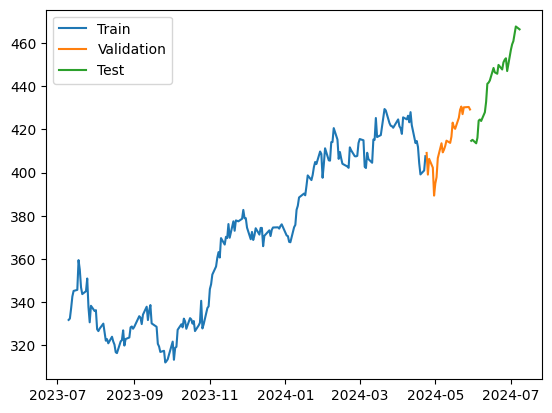

In [22]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [24]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 127ms/step - loss: 136147.3438 - mean_absolute_error: 367.1641 - val_loss: 170569.7188 - val_mean_absolute_error: 412.8316
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 135601.5938 - mean_absolute_error: 366.4186 - val_loss: 169958.1875 - val_mean_absolute_error: 412.0902
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 135020.7812 - mean_absolute_error: 365.6266 - val_loss: 169237.2656 - val_mean_absolute_error: 411.2146
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 134277.5938 - mean_absolute_error: 364.6071 - val_loss: 168141.1562 - val_mean_absolute_error: 409.8797
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 133164.8438 - mean_absolute_error: 363.0824 - val_loss: 166658.5156 - val_mean_absolute_error: 408.0669
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 131597.3438 - mean_absolute_error: 360.9092 - v

7/7 [==============================] - 0s 2ms/step


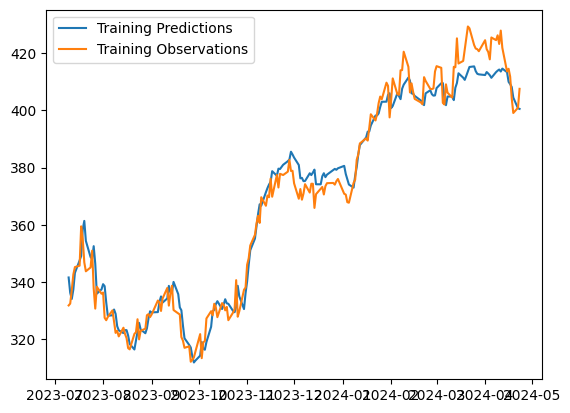

In [25]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 20ms/step


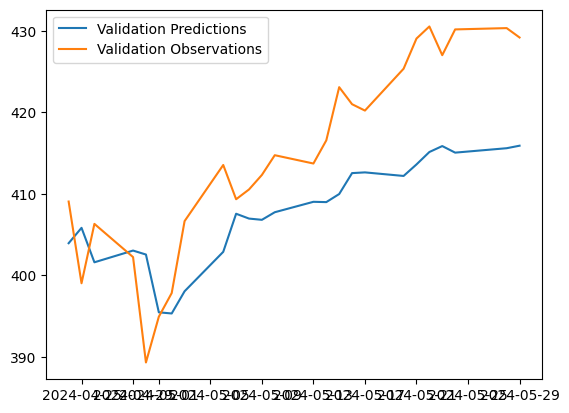

In [26]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 19ms/step


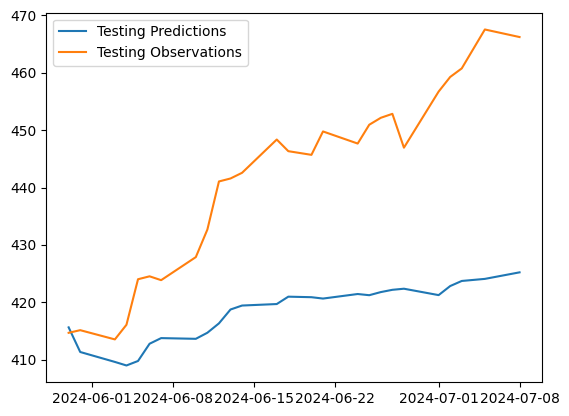

In [27]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

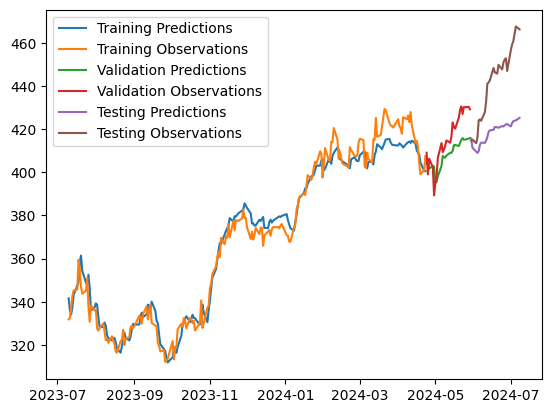

In [28]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [29]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 19ms/step


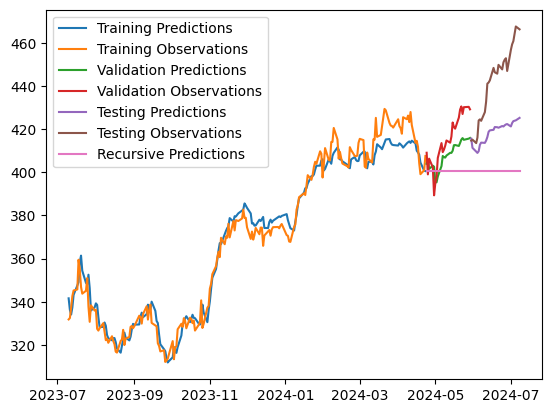

In [30]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])